In [1]:
import numpy as np
from matplotlib import cm as colormap
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from ipywidgets import widgets
from IPython.display import display
from io import BytesIO

In [2]:
BASE_DIR = 'D:/Kuliah/Skripsi/plant-images-dataset'
print(f"list directory: {sorted(os.listdir(BASE_DIR))}")

TRAIN_DIR = os.path.join(BASE_DIR, 'train')
print(f"train directory: {sorted(os.listdir(TRAIN_DIR))}")

TEST_DIR = os.path.join(BASE_DIR, 'test')
print(f"test directory: {sorted(os.listdir(TEST_DIR))}")

VAL_DIR = os.path.join(BASE_DIR, 'val')
print(f"validation directory: {sorted(os.listdir(VAL_DIR))}")

list directory: ['test', 'train', 'val']
train directory: ['Bayam', 'Jagung', 'Jambu Air', 'Jambu Biji', 'Jeruk', 'Kacang Panjang', 'Kangkung', 'Kelapa', 'Kentang', 'Kubis', 'Mangga', 'Melon', 'Mentimun', 'Nanas', 'Pepaya', 'Pisang', 'Semangka', 'Singkong', 'Terung', 'Tomat', 'Ubi Ungu', 'Wortel']
test directory: ['Bayam', 'Jagung', 'Jambu Air', 'Jambu Biji', 'Jeruk', 'Kacang Panjang', 'Kangkung', 'Kelapa', 'Kentang', 'Kubis', 'Mangga', 'Melon', 'Mentimun', 'Nanas', 'Pepaya', 'Pisang', 'Semangka', 'Singkong', 'Terung', 'Tomat', 'Ubi Ungu', 'Wortel']
validation directory: ['Bayam', 'Jagung', 'Jambu Air', 'Jambu Biji', 'Jeruk', 'Kacang Panjang', 'Kangkung', 'Kelapa', 'Kentang', 'Kubis', 'Mangga', 'Melon', 'Mentimun', 'Nanas', 'Pepaya', 'Pisang', 'Semangka', 'Singkong', 'Terung', 'Tomat', 'Ubi Ungu', 'Wortel']


In [3]:
def plot_data(PATH, title, num_classes, column):
  data_list = os.listdir(PATH)

  fig, axes = plt.subplots(num_classes//3+1, column, figsize=(12, 12))
  fig.suptitle(f'{title} Images', fontsize=16)

  #plot gambar untuk tiap data
  for ii, data in enumerate(data_list):
    dir_path = f'{PATH}/{data}'
    img = tf.keras.preprocessing.image.load_img(dir_path + '/' + os.listdir(dir_path)[0])
    row, col = divmod(ii, column)
    axes[row, col].imshow(img)
    axes[row, col].set_title(f'Example of {title}: {data}')
    axes[row, col].axis('off')

  #hilangkan axis kosong
  for jj in range(len(data_list), 24):
    row, col = divmod(jj, column)
    axes[row, col].axis('off')

  plt.show()

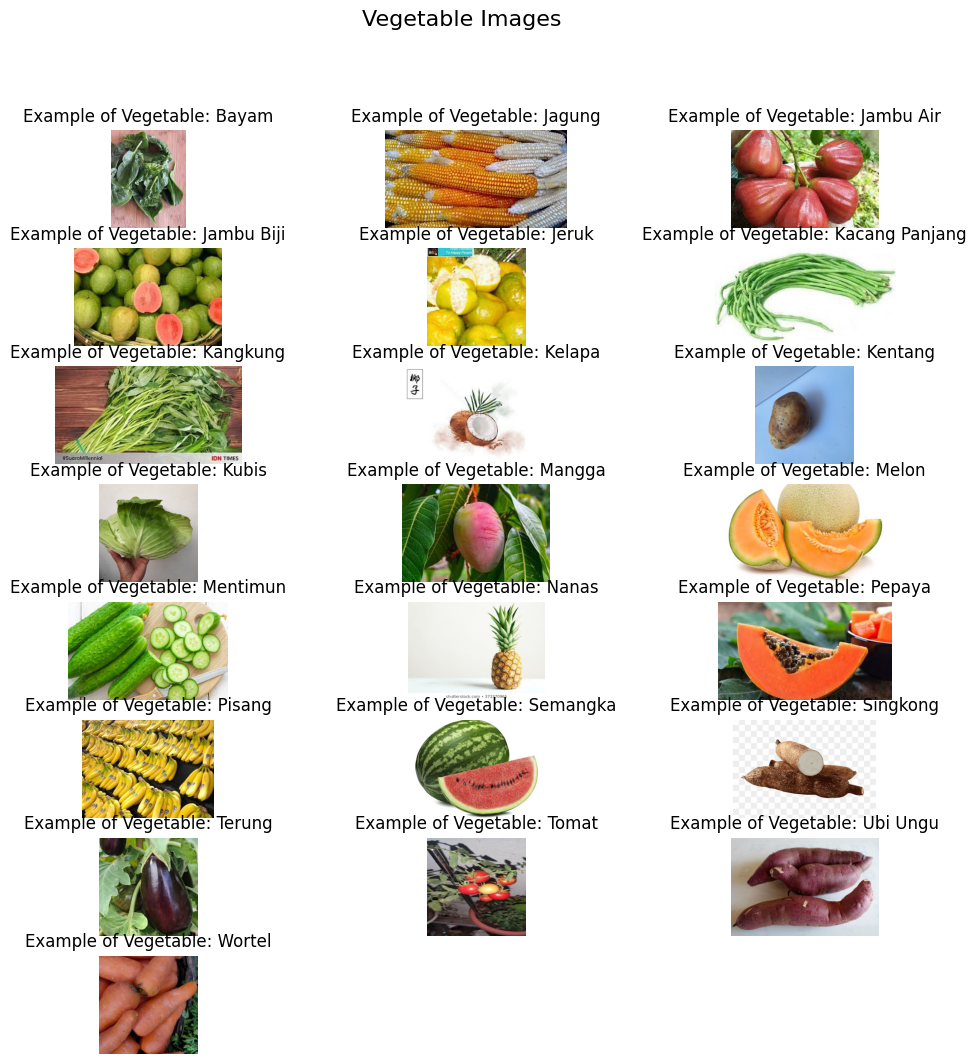

In [4]:
NUM_CLASSES = len(os.listdir(TRAIN_DIR))
plot_data(TRAIN_DIR, 'Vegetable', NUM_CLASSES, 3)

In [5]:
def get_image_array(classname):
  dir_path = f'{TRAIN_DIR}/{classname}'
  img = tf.keras.preprocessing.image.load_img(dir_path + '/' + os.listdir(dir_path)[0])
  array = tf.keras.preprocessing.image.img_to_array(img)
  return array

In [6]:
sample_array = get_image_array('Pisang')
print(f"Each image has size: {sample_array.shape}")
sample_array[0,:5]

Each image has size: (194, 259, 3)


array([[213., 153.,  57.],
       [244., 187.,  84.],
       [252., 197.,  81.],
       [212., 162.,  41.],
       [208., 158.,  45.]], dtype=float32)

In [7]:
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=10,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    vertical_flip=True,
                    fill_mode='reflect')

valid_datagen = ImageDataGenerator(
                    rescale=1./255)

test_datagen = ImageDataGenerator(
                    rescale=1./255)

In [8]:
def load_generator(datagen, PATH, IMAGE_SIZE, BATCH_SIZE, LABEL_MODE):
  generator = datagen.flow_from_directory(
    PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=LABEL_MODE,
    shuffle=False if PATH == TEST_DIR else True,
    seed=42
  )
  return generator

In [9]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
LABEL_MODE = 'categorical'
BUFFER_SIZE = tf.data.AUTOTUNE

train_generator = load_generator(train_datagen, TRAIN_DIR, IMAGE_SIZE, BATCH_SIZE, LABEL_MODE)
validation_generator = load_generator(valid_datagen, VAL_DIR, IMAGE_SIZE, BATCH_SIZE, LABEL_MODE)
test_generator = load_generator(test_datagen, TEST_DIR, IMAGE_SIZE, BATCH_SIZE, LABEL_MODE)

Found 9856 images belonging to 22 classes.
Found 2464 images belonging to 22 classes.
Found 3080 images belonging to 22 classes.


In [10]:
pretrained_model = NASNetMobile(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

pretrained_model.trainable = False

In [11]:
checkpoint_path = "D:/Kuliah/Skripsi/NasNetMobile/model_checkpoint.weights.h5"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

In [12]:
def build_model(base_model):
  model = Sequential(
    [
        base_model,
        Flatten(),
        Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        # Dropout(0.2),
        Dense(NUM_CLASSES, activation='softmax')
    ]
  )
  return model

In [13]:
model = build_model(pretrained_model)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ nasnet_mobile (Functional)      │ (None, 7, 7, 1056)     │     4,269,716 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51744)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     3,311,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 22)             │         1,430 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,583,082 (28.93 MB)

 Trainable params: 3,313,238 (12.64 MB)

 Non-trainable params: 4,269,844 (16.29 MB)

In [14]:
LEARNING_RATE = 0.001
EPOCHS = 50
model.compile(
    loss=CategoricalCrossentropy(),
    optimizer=Adam(learning_rate=LEARNING_RATE),
    metrics=['accuracy']
)

In [15]:
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[checkpoint_callback]
)

c:\Users\ALFIAN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 473s 1s/step - accuracy: 0.6372 - loss: 1.2879 - val_accuracy: 0.7983 - val_loss: 0.7038
Epoch 2/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 452s 1s/step - accuracy: 0.8239 - loss: 0.6064 - val_accuracy: 0.8580 - val_loss: 0.4676
Epoch 3/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 450s 1s/step - accuracy: 0.8588 - loss: 0.4720 - val_accuracy: 0.8718 - val_loss: 0.4405
Epoch 4/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 444s 1s/step - accuracy: 0.8721 - loss: 0.4029 - val_accuracy: 0.8758 - val_loss: 0.4149
Epoch 5/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 449s 1s/step - accuracy: 0.8897 - loss: 0.3747 - val_accuracy: 0.8803 - val_loss: 0.3968
Epoch 6/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 456s 1s/step - accuracy: 0.8911 - loss: 0.3563 - val_accuracy: 0.8888 - val_loss: 0.3726
Epoch 7/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 470s 2s/step - accuracy: 0.8965 - loss: 0.3334 - val_accuracy: 0.8799 - val_loss: 0.3852
Epoch 8/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 460s 1s/step - accuracy: 0.9037 - loss: 0.3132 - val_accu

In [16]:
def plot_metrics(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  fig, ax = plt.subplots(1, 2, figsize=(12, 6))
  fig.suptitle('Training and Validation Metrics')

  for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
      ax[i].plot(epochs, data[0], 'orange', label="Training " + label)
      ax[i].plot(epochs, data[1], 'steelblue', label="Validation " + label)
      ax[i].legend()
      ax[i].set_xlabel('epochs')

  plt.show()

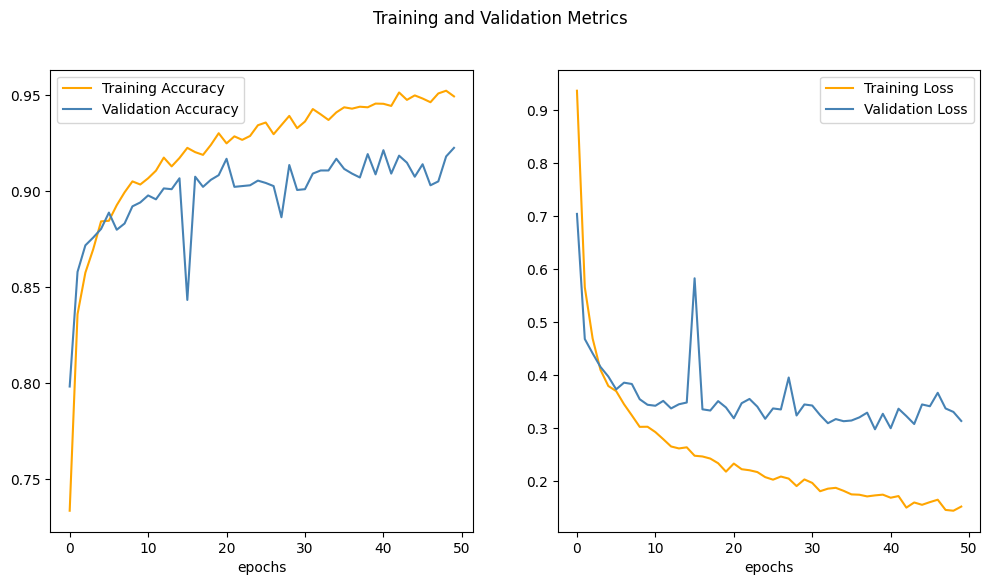

In [17]:
plot_metrics(history)

In [18]:
num_test_files = sum([len(files) for r, d, files in os.walk(TEST_DIR)])
num_test_steps = num_test_files // BATCH_SIZE

acc = model.evaluate(test_generator, batch_size=BATCH_SIZE, verbose=1, steps=num_test_steps)[1] * 100
print(f"Accuracy on the test set is {acc:.2f} %")

96/96 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.9254 - loss: 0.3199
Accuracy on the test set is 93.39 %


97/97 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step


C:\Users\ALFIAN\AppData\Local\Temp\ipykernel_10244\1543736279.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = colormap.get_cmap('tab10', len(filtered_labels)).colors


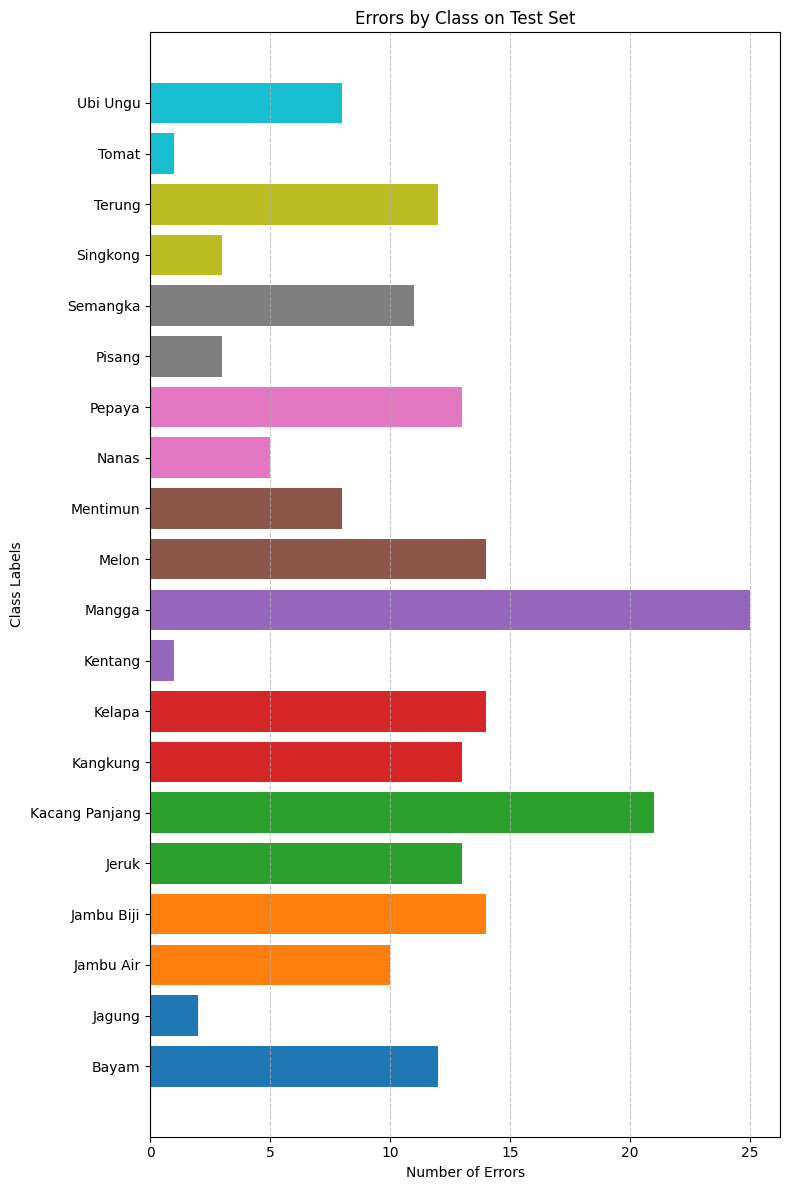

In [19]:
predictions = model.predict(test_generator, verbose=1)

y_true = test_generator.classes
y_pred = np.argmax(predictions, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred)
errors_per_class = conf_matrix.sum(axis=1) - np.diag(conf_matrix)

class_labels = list(test_generator.class_indices.keys())

filtered_labels = [label for label, errors in zip(class_labels, errors_per_class) if errors > 0]
filtered_errors = [errors for errors in errors_per_class if errors > 0]

colors = colormap.get_cmap('tab10', len(filtered_labels)).colors

plt.figure(figsize=(8, len(filtered_labels) * 0.6))
plt.barh(filtered_labels, filtered_errors, color=colors)
plt.title('Errors by Class on Test Set', fontsize=12)
plt.xlabel('Number of Errors', fontsize=10)
plt.ylabel('Class Labels', fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

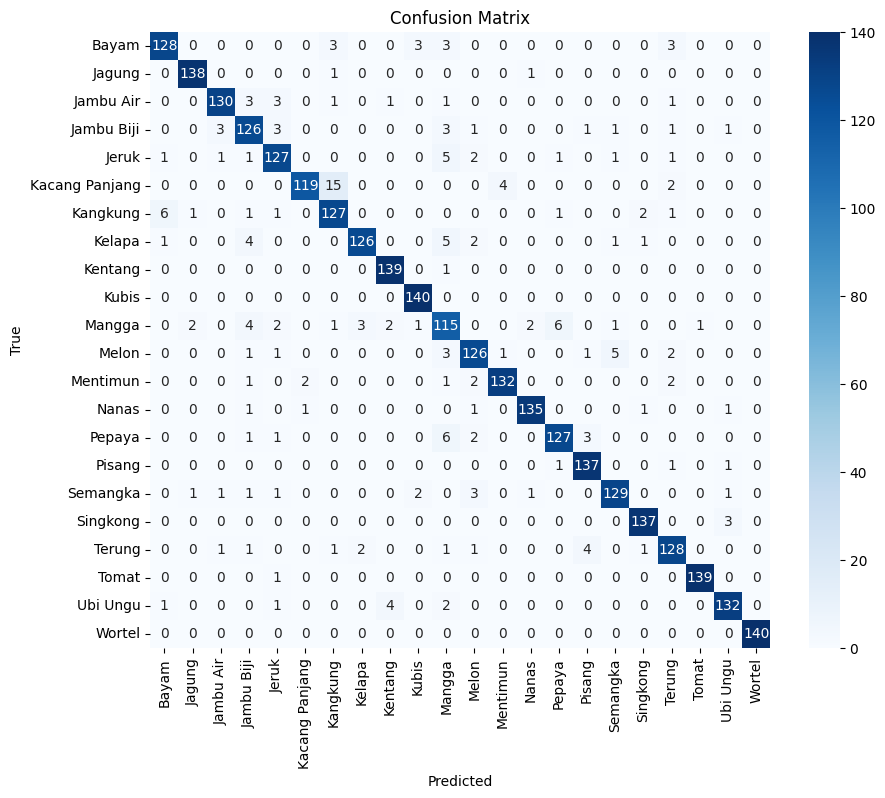

In [20]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [21]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

Classification Report:
                precision    recall  f1-score   support

         Bayam       0.93      0.91      0.92       140
        Jagung       0.97      0.99      0.98       140
     Jambu Air       0.96      0.93      0.94       140
    Jambu Biji       0.87      0.90      0.88       140
         Jeruk       0.90      0.91      0.90       140
Kacang Panjang       0.98      0.85      0.91       140
      Kangkung       0.85      0.91      0.88       140
        Kelapa       0.96      0.90      0.93       140
       Kentang       0.95      0.99      0.97       140
         Kubis       0.96      1.00      0.98       140
        Mangga       0.79      0.82      0.80       140
         Melon       0.90      0.90      0.90       140
      Mentimun       0.96      0.94      0.95       140
         Nanas       0.97      0.96      0.97       140
        Pepaya       0.93      0.91      0.92       140
        Pisang       0.94      0.98      0.96       140
      Semangka       0.9

In [22]:
def process_image(image_path, target_size=(224, 224)):

    image = tf.keras.utils.load_img(image_path, target_size=target_size)
    image_array = tf.keras.utils.img_to_array(image) / 255.0
    image_array = np.expand_dims(image_array, axis=0)
    return image_array

def predict_image(model, file_content, class_labels):

    image = tf.keras.utils.load_img(BytesIO(file_content), target_size=(224, 224))
    processed_image = tf.keras.utils.img_to_array(image) / 255.0
    processed_image = np.expand_dims(processed_image, axis=0)

    prediction = model.predict(processed_image)[0]
    predicted_class = np.argmax(prediction)

    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Predicted: {class_labels[predicted_class]} (Confidence: {prediction[predicted_class]*100:.2f}%)")
    plt.show()

    print("Prediction Probabilities:")
    for i, prob in enumerate(prediction):
        print(f"{class_labels[i]}: {prob*100:.2f}%")

uploader = widgets.FileUpload(accept="image/*", multiple=False)
display(uploader)

output = widgets.Output()
display(output)

def on_file_upload(change):
    with output:
        output.clear_output()
        for filename, file_info in uploader.value.items():
            file_content = file_info["content"]
            print(f"Processing file: {filename}")
            #Predict Image
            predict_image(model_to_use, file_content, class_labels)

class_labels = list(test_generator.class_indices.keys())

model_to_use = model

uploader.observe(on_file_upload, names="value")

FileUpload(value=(), accept='image/*', description='Upload')

Output()

In [25]:
model.save("D:/Kuliah/Skripsi/NasNetMobile/model_nasnet.h5")